# Diff

http://pcfarina.eng.unipr.it/Differentiation_Integration.htm

# `hmmlearn`

Does not seem to work with `scikit-learn` 0.2.

    conda install -c omnia hmmlearn=0.3.0b=np112py36_0
    conda install -c omnia scikit-learn=0.19.1=py36hedc7406_0


# FFT

https://www.oreilly.com/library/view/elegant-scipy/9781491922927/ch04.html

In [105]:
import random
import numpy as np
import pandas as pd

In [51]:
no_accel_samples = 100
window_accel_samples = 10
acceleration_model_function = np.random.random

In [1]:
import numpy as np
from hmmlearn import hmm

In [807]:
# GENERATE

# Probabilities too high for 900 samples
n_samples = 900


np.random.seed(42)


# Numer of components, i.e. number of classifications
# 0 ruminating
# 1 eating 
# 2 other
# 3 ruminating while ill
# 4 eating while ill
# 5 other whilt ill
n_components = 6

model = hmm.GaussianHMM(n_components=n_components
                        , covariance_type="full")

# Start probabilities
p_start_rum_wel = 0.6-0.01
p_start_eat_wel = 0.3-0.01
p_start_oth_wel = 0.1-0.01
p_start_rum_ill = 0.01
p_start_eat_ill = 0.01
p_start_oth_ill = 0.01
# p_start_rum_wel = 1.0
# p_start_eat_wel = 0.0
# p_start_oth_wel = 0.0
# p_start_rum_ill = 0.0
# p_start_eat_ill = 0.0
# p_start_oth_ill = 0.0

# Probability delta-in-transition from well to ill
# p_d_wel_to_ill = 0.0 # 0.01
p_d_wel_to_ill = 0.01
p_d_ill_to_well = 0.1

###############################################################################
# Base probability transitions
# Without taking into account 
# wellness and illness
###############################################################################

# Probability of transition from rumination
#p_trans_rum_to_rum = 1.0
#p_trans_rum_to_eat = 0.0
#p_trans_rum_to_oth = 0.0
p_trans_rum_to_rum = 0.7
p_trans_rum_to_eat = 0.2
p_trans_rum_to_oth = 0.1

# Probability of transition from eating
p_trans_eat_to_rum = 0.3
p_trans_eat_to_eat = 0.5
p_trans_eat_to_oth = 0.2

# Probability of transition from other
p_trans_oth_to_rum = 0.3
p_trans_oth_to_eat = 0.3
p_trans_oth_to_oth = 0.4

###############################################################################
# Transition proabiities with sickness and wellness 
###############################################################################

# Prob of transition from rumination
p_trans_rum_wel_to_rum_wel = p_trans_rum_to_rum - p_d_wel_to_ill
p_trans_rum_wel_to_eat_wel = p_trans_rum_to_eat - p_d_wel_to_ill
p_trans_rum_wel_to_oth_wel = p_trans_rum_to_oth - p_d_wel_to_ill
p_trans_rum_wel_to_rum_ill = p_d_wel_to_ill
p_trans_rum_wel_to_eat_ill = p_d_wel_to_ill
p_trans_rum_wel_to_oth_ill = p_d_wel_to_ill

#print(p_trans_rum_wel_to_rum_wel
#    , p_trans_rum_wel_to_eat_wel
#    , p_trans_rum_wel_to_oth_wel
#    , p_trans_rum_wel_to_rum_ill
#    , p_trans_rum_wel_to_eat_ill
#    , p_trans_rum_wel_to_oth_ill)



# Prob of transition from eating
p_trans_eat_wel_to_rum_wel = p_trans_eat_to_rum-p_d_wel_to_ill
p_trans_eat_wel_to_eat_wel = p_trans_eat_to_eat-p_d_wel_to_ill
p_trans_eat_wel_to_oth_wel = p_trans_eat_to_oth-p_d_wel_to_ill
p_trans_eat_wel_to_rum_ill = p_d_wel_to_ill
p_trans_eat_wel_to_eat_ill = p_d_wel_to_ill
p_trans_eat_wel_to_oth_ill = p_d_wel_to_ill

# Prob of transition from other
p_trans_oth_wel_to_rum_wel = p_trans_oth_to_rum-p_d_wel_to_ill
p_trans_oth_wel_to_eat_wel = p_trans_oth_to_eat-p_d_wel_to_ill
p_trans_oth_wel_to_oth_wel = p_trans_oth_to_oth-p_d_wel_to_ill
p_trans_oth_wel_to_rum_ill = p_d_wel_to_ill
p_trans_oth_wel_to_eat_ill = p_d_wel_to_ill
p_trans_oth_wel_to_oth_ill = p_d_wel_to_ill

# SICK
# Prob of transition from rumination sick
p_trans_rum_ill_to_rum_wel = p_d_ill_to_well
p_trans_rum_ill_to_eat_wel = p_d_ill_to_well
p_trans_rum_ill_to_oth_wel = p_d_ill_to_well
p_trans_rum_ill_to_rum_ill = p_trans_rum_to_rum - p_d_ill_to_well
p_trans_rum_ill_to_eat_ill = p_trans_rum_to_eat - p_d_ill_to_well
p_trans_rum_ill_to_oth_ill = p_trans_rum_to_oth - p_d_ill_to_well

# Prob of transition from eating sick
p_trans_eat_ill_to_rum_wel = p_d_ill_to_well
p_trans_eat_ill_to_eat_wel = p_d_ill_to_well
p_trans_eat_ill_to_oth_wel = p_d_ill_to_well
p_trans_eat_ill_to_rum_ill = p_trans_eat_to_rum - p_d_ill_to_well
p_trans_eat_ill_to_eat_ill = p_trans_eat_to_eat - p_d_ill_to_well
p_trans_eat_ill_to_oth_ill = p_trans_eat_to_oth - p_d_ill_to_well

# Prob of transition from other sick
p_trans_oth_ill_to_rum_wel = p_d_ill_to_well
p_trans_oth_ill_to_eat_wel = p_d_ill_to_well
p_trans_oth_ill_to_oth_wel = p_d_ill_to_well
p_trans_oth_ill_to_rum_ill = p_trans_oth_to_rum - p_d_ill_to_well
p_trans_oth_ill_to_eat_ill = p_trans_oth_to_eat - p_d_ill_to_well
p_trans_oth_ill_to_oth_ill = p_trans_oth_to_oth - p_d_ill_to_well

# Setting start probabilities 
model.startprob_ = np.array([p_start_rum_wel
                             , p_start_eat_wel
                             , p_start_oth_wel
                             , p_start_rum_ill
                             , p_start_eat_ill
                             , p_start_oth_ill])

model.transmat_ = np.array([[p_trans_rum_wel_to_rum_wel # 0 to
                             , p_trans_rum_wel_to_eat_wel # 0 to
                             , p_trans_rum_wel_to_oth_wel # 0 to
                             , p_trans_rum_wel_to_rum_ill # 0 to
                             , p_trans_rum_wel_to_eat_ill # 0 to
                             , p_trans_rum_wel_to_oth_ill], # 0 to
                            [p_trans_eat_wel_to_rum_wel # 1
                             , p_trans_eat_wel_to_eat_wel # 1
                             , p_trans_eat_wel_to_oth_wel # 1
                             , p_trans_eat_wel_to_rum_ill # 1
                             , p_trans_eat_wel_to_eat_ill # 1
                             , p_trans_eat_wel_to_oth_ill], # 1
                            [p_trans_oth_wel_to_rum_wel # 2
                             , p_trans_oth_wel_to_eat_wel # 2
                             , p_trans_oth_wel_to_oth_wel # 2
                             , p_trans_oth_wel_to_rum_ill # 2
                             , p_trans_oth_wel_to_eat_ill # 2
                             , p_trans_oth_wel_to_oth_ill], # 2
                            # Ill ruminating to 
                            [p_trans_rum_ill_to_rum_wel # 3
                             , p_trans_rum_ill_to_eat_wel # 3
                             , p_trans_rum_ill_to_oth_wel # 3
                             , p_trans_rum_ill_to_rum_ill # 3
                             , p_trans_rum_ill_to_eat_ill # 3
                             , p_trans_rum_ill_to_oth_ill], # 3
                            # Ill eating to
                            [p_trans_eat_ill_to_rum_wel # 4
                             , p_trans_eat_ill_to_eat_wel # 4
                             , p_trans_eat_ill_to_oth_wel # 4
                             , p_trans_eat_ill_to_rum_ill # 4
                             , p_trans_eat_ill_to_eat_ill # 4
                             , p_trans_eat_ill_to_oth_ill], # 4
                            # 5 Ill other to 
                            [p_trans_oth_ill_to_rum_wel # 5 
                             , p_trans_oth_ill_to_eat_wel # 5
                             , p_trans_oth_ill_to_oth_wel # 5
                             , p_trans_oth_ill_to_rum_ill # 5
                             , p_trans_oth_ill_to_eat_ill # 5
                             , p_trans_oth_ill_to_oth_ill] # 5
                           ])



###############################################################################
# EMMISSIONS
###############################################################################

# cols
# 1. frequency peak location - about 2.5
# 2. frequency peak magnitude - value to be investigated
# 3. variance of noise magnitude - zero

# TODO: when not in rumination, does it's magnitude drop or does it just become
# a messier signal. Possibly, messier as the noise it fixed.
# This is, unless the variance noise variance is being used as a eating proxi

model.means_ = np.array([
      
      [2.5,  1.0, 0.0]    # 0 - rum 
    , [2.5,  0.1, 0.0]    # 1 - eat
    , [2.5,  0.1, 0.0]    # 2
    , [2.5,  1.0, 0.0]    # 3
    , [2.5,  0.1, 0.0]    # 4
    , [2.5,  0.1, 0.0]    # 5

])

#model.covars_ = np.tile(np.identity(3), (n_components, 1, 1))

# TODO: INteresting... Increasing the variance of the peak locations, ends up
# making the signal a mess. Is it possible that increaing the variance in the 
# frequency can replace the variance or/and frequency peakmagnitude variance.
# 
# What is one peak random is the same a random signal.
#
# If not the above then I think that we may nonnt need a variance in the 
# frequency magnitude (2) and the noise vaue (3). However, as the noise is 
# real maybe it is easier to characterise this on its own. It is possile that
# the characterisation of the apmplitude noise might be a function of the amplitude
# and is easier to handle separately.
#
###############################################################################
# Emission covariances 
###############################################################################
#
# 1. Frequency peak location variance. This has to be samll or the signal is 
#  lost.
# 2. Frequency peak magnitude variance. Value to be investigated.
# 3. Variance magnitude. This output value is used directly as the noise. Value
#  still to be investigated
# 
#
# [[1 - -]
#  [- 2 -]
#  [- - 3]]
#
#

emission_frequency_peak_variance = 0.0001
emission_frequency_peak_magnitude_variance = 2.0
emission_noise_variance = 0.1

# No covarience assumed

covarance_matrix = [
     [emission_frequency_peak_variance, 0., 0.],
     [0., emission_frequency_peak_magnitude_variance, 0.],
     [0., 0., emission_noise_variance]]

model.covars_ = np.array([    
       # Covariances of the outputs when the cow is ruminating
       covarance_matrix

       # Covariances of the outputs when the cow is eating     
       , covarance_matrix

       # Covariances of the outputs when the cow is other
       , covarance_matrix
    
       # Covariances of the outputs when the cow is ruminating ill
       , covarance_matrix
    
       # Covariances of the outputs when the cow is eating ill
       , covarance_matrix
    
       # Covariances of the outputs when the cow is other ill
       , covarance_matrix])

X, Z = model.sample(n_samples)

features = pd.DataFrame(X, columns=['f_peak', 'f_magnitude', 'variance'])

In [799]:
X

array([[ 2.50318902e+00, -5.72435943e-01,  8.82406045e-05],
       [ 2.51715726e+00,  1.11051528e+00,  3.53052561e+00],
       [ 2.49075917e+00,  1.91946420e-01, -8.26160538e-04],
       ...,
       [ 2.44678314e+00, -4.89567384e-01, -2.92625347e-01],
       [ 2.53609627e+00,  4.25840852e-01,  5.20834782e+00],
       [ 2.53482689e+00, -4.59329938e-01,  4.44419833e+00]])

### FFT

In [748]:
import numpy as np
from scipy import pi
import matplotlib.pyplot as plt
%matplotlib inline

# Sampling rate and time vector
start_time = 0 # seconds
end_time = 90 # seconds
sampling_rate = 10 # Hz
N = (end_time - start_time)*sampling_rate # array size

# Frequency domain peaks
peak1_hz = 2.5 # Hz where the peak occurs
peak1_mag = 1 # magnitude of the peak
peak2_hz = 2.6 # Hz where the peak occurs
peak2_mag = 0.5 # magnitude of the peak

# Noise control
noise_loc = 0 # the Gaussian noise is mean-centered
noise_mag = 2.0 # magnitude of added noise

# Vibration data generation
time = np.linspace(start_time, end_time, N)
#vib_data = (peak1_mag*np.sin(2*pi*peak1_hz*time) 
#            + np.random.normal(0, noise_mag, N) 
#           # + peak2_mag*np.sin(2*pi*peak2_hz*time) 
#           )

#vib_data = np.zeros(N)

#for v, x in zip(vib_data, X):
#    print(v, x)
    

# Data plotting
#plt.plot(time, vib_data)
#plt.xlabel('Time')
#plt.ylabel('Vibration (g)')
#plt.title('Time Domain (Healthy Machinery)');

In [749]:
features['time'] = time

In [750]:
features.head()

,f_peak,f_magnitude,variance,time
0,1.003189,-0.572436,0.000088,0.000000
1,0.995305,2.429084,0.000172,0.100111
2,0.990759,0.191946,-0.000826,0.200222
3,0.989872,2.344026,0.000099,0.300334
4,0.978604,0.005322,-0.000199,0.400445


In [789]:
features['signal'] = (#1.0#features['f_magnitude']
     
                      #*np.sin(2*pi*features['f_peak']*features['time'])
                      #+ np.sin(2*pi*2.5*features['time'])
                      + np.sin(2*pi*1.8*features['time'])
                      #+ np.random.normal(0, features['variance']**2)
                      #+ features['variance']
                     )

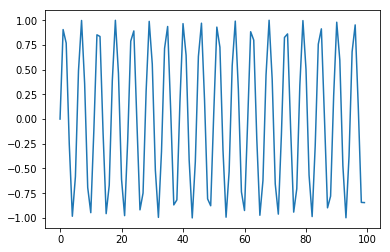

In [790]:
features['signal'][0:100].plot()

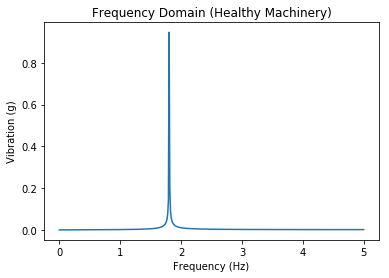

In [791]:
from scipy.fftpack import fft

# Nyquist Sampling Criteria
T = 1/sampling_rate # inverse of the sampling rate
x = np.linspace(0.0, 1.0/(2.0*T), int(N/2))

# FFT algorithm
vib_data = features['signal']
yr = fft(vib_data) # "raw" FFT with both + and - frequencies
y = 2/N * np.abs(yr[0:np.int(N/2)]) # positive freqs only

# Plotting the results
plt.plot(x, y)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Vibration (g)')
plt.title('Frequency Domain (Healthy Machinery)');

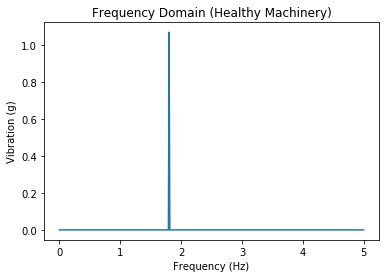

In [792]:
from scipy.fftpack import fft

# Nyquist Sampling Criteria
T = 1/sampling_rate # inverse of the sampling rate
x = np.linspace(0.0, 1.0/(2.0*T), int(N/2))

# FFT algorithm
vib_data = features['signal']
yr = fft(vib_data.diff()[1:]) # "raw" FFT with both + and - frequencies
y = 2/N * np.abs(yr[0:np.int(N/2)]) # positive freqs only

# Plotting the results
plt.plot(x, y)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Vibration (g)')
plt.title('Frequency Domain (Healthy Machinery)');

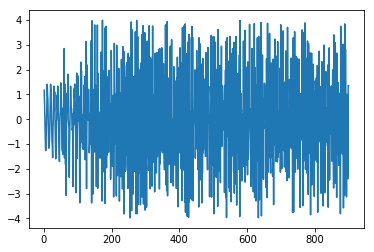

In [755]:
vib_data.diff()[1:].plot()

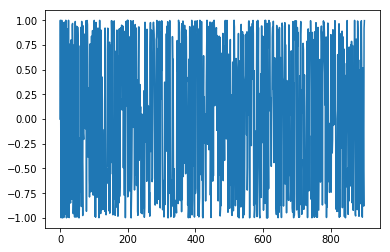

In [662]:
vib_data.plot()

In [663]:
vib_data.sum()

9.01762174017787

In [595]:
vib_data.diff().sum()

0.48500671198213663

In [503]:
from scipy.fftpack import ifft
iii = np.real(ifft(yr))

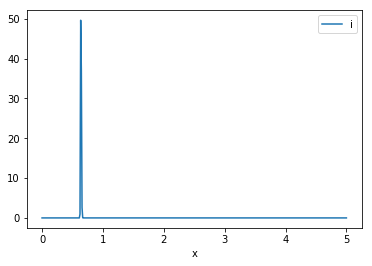

In [320]:
import scipy.stats
#fff = scipy.stats.norm(2.5, 0.001).pdf(x)
#fff = scipy.stats.poisson(2.5)#.pmf(k=x)#.pdf(x)
#fff = scipy.stats.poisson(2.5).cdf(x)#.pmf(k=x)#.pdf(x)
fff = scipy.stats.gamma(40.0, 0.6, 0.001).pdf(x)

#fff = np.zeros(len(x))

#fff[200] = 1.0

df = pd.DataFrame({'i':fff, 'x':x})#.plot(x='x', y='i')

df.plot(x='x', y='i')

In [321]:
def ffff(row):
    #print(row)
    return row.i * np.sin(2*pi*row.x*time) 


df_sin = df.apply(ffff, axis=1, result_type='expand')

In [322]:
df_sin_sum = df_sin.sum()

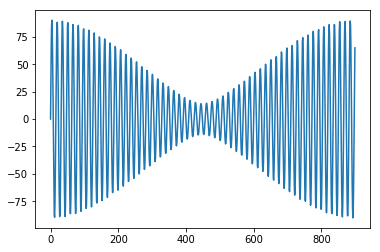

In [323]:
df_sin_sum.plot()

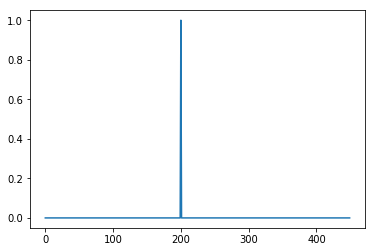

In [168]:
df.i.plot()

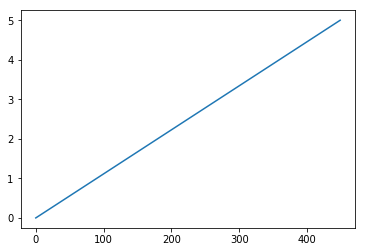

In [169]:
df.x.plot()

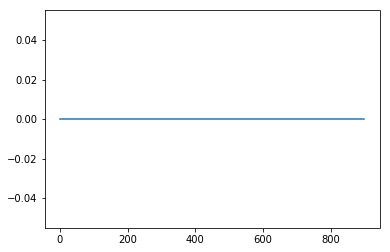

In [170]:
df_sin.iloc[10].plot()

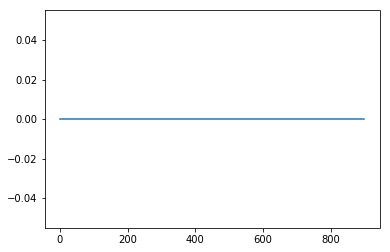

In [171]:
df_sin.iloc[100].plot()

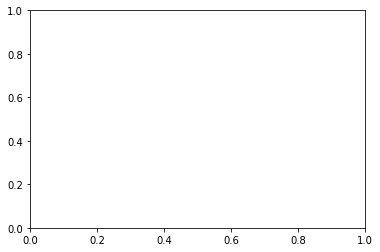

In [198]:
from scipy.stats import poisson
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

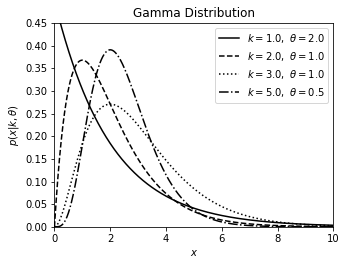

In [257]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from scipy.stats import gamma
from matplotlib import pyplot as plt

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
#from astroML.plotting import setup_text_plots
#setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# plot the distributions
k_values = [1, 2, 3, 5]
theta_values = [2, 1, 1, 0.5]
linestyles = ['-', '--', ':', '-.']
x = np.linspace(1E-6, 10, 1000)

#------------------------------------------------------------
# plot the distributions
fig, ax = plt.subplots(figsize=(5, 3.75))

for k, t, ls in zip(k_values, theta_values, linestyles):
    dist = gamma(k, 0, t)
    plt.plot(x, dist.pdf(x), ls=ls, c='black',
             label=r'$k=%.1f,\ \theta=%.1f$' % (k, t))

plt.xlim(0, 10)
plt.ylim(0, 0.45)

plt.xlabel('$x$')
plt.ylabel(r'$p(x|k,\theta)$')
plt.title('Gamma Distribution')

plt.legend(loc=0)
plt.show()

In [53]:
def features(acceleration_df
             , window_accel_samples
             , feature_function):
    
    length = len(acceleration_df)
    grouper = np.arange(length, dtype=int)//window_accel_samples
    
    return acceleration_df.groupby(grouper).apply(feature_function)

In [54]:
a_df = accelerometer(no_accel_samples=no_accel_samples
    , acceleration_model_function=acceleration_model_function)

f_df = features(acceleration_df=a_df
             ,window_accel_samples=window_accel_samples
             ,feature_function=sum)

In [52]:
def accelerometer(
    no_accel_samples
    , acceleration_model_function):
    
    return pd.DataFrame(
        {'acceleration':
             acceleration_model_function(
                 number_of_accelerometer_samples)})